In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

Data = pd.read_csv("Data/clean_data_imputed_clustered_missForest.csv")

In [2]:
def model_logistic(df_train, feature_cols, label = 'Tranexamic.acid', show = True):
    
    data_train, data_valid, Y_train, Y_valid = train_test_split(df_train[feature_cols], df_train[label], test_size=1/5.0, random_state=0)

    clf = LogisticRegression(random_state=0, solver = 'liblinear', class_weight= 'balanced', max_iter = 500, penalty = 'l1', tol = 0.001).fit(data_train, Y_train)

    train_pred = clf.predict_proba(data_train)[:,1]
    train_score = metrics.roc_auc_score(Y_train, train_pred)
    valid_pred = clf.predict_proba(data_valid)[:,1]
    valid_score = metrics.roc_auc_score(Y_valid, valid_pred)
    
    if show:
        print("Training model!")
        print(f"Train AUC score: {train_score}")
        print(f"Validation AUC score: {valid_score}")
    
    return clf

def model_lgb(df_train, feature_cols, label = 'Tranexamic.acid', show = True, is_unbalanced = True):
        
    data_train, data_valid, Y_train, Y_valid = train_test_split(df_train[feature_cols], df_train[label], test_size=1/5.0, random_state=0)

    params = {'metric' : 'auc',
              'boosting_type' : 'gbdt',
              'objective' : 'binary',
              'is_unbalance' : is_unbalanced
    }

    dtrain = lgb.Dataset(data_train, label=Y_train)
    dvalid = lgb.Dataset(data_valid, label=Y_valid)

    num_round = 10000
    bst = lgb.train(params, dtrain, num_round, valid_sets=[dvalid], 
                        early_stopping_rounds=40, verbose_eval=False)
    
    train_pred = bst.predict(data_train)
    train_score = metrics.roc_auc_score(Y_train, train_pred)
    valid_pred = bst.predict(data_valid)
    valid_score = metrics.roc_auc_score(Y_valid, valid_pred)
    if show:
        print("Training model!")
        print(f"Train AUC score: {train_score}")
        print(f"Validation AUC score: {valid_score}")

    return bst


def model_XGB(df_train, feature_cols, label = 'Tranexamic.acid', show = True):
    
    
    scale_pos_weight = df_train[label].value_counts(normalize = True).values[1]
    data_train, data_valid, Y_train, Y_valid = train_test_split(df_train[feature_cols], df_train[label], test_size=1/4.0, random_state=0)
    boost=xgb.XGBClassifier(random_state=0,learning_rate=0.1, max_depth = 4,gamma = 0.2, min_child_weight = 6, subsample = 0.8, colsample_bytree = 0.8, scale_pos_weight = 1)
    boost.fit(data_train, Y_train)
    train_pred = boost.predict_proba(data_train)[:,1]
    train_score = metrics.roc_auc_score(Y_train, train_pred)
    valid_pred = boost.predict_proba(data_valid)[:,1]
    valid_score = metrics.roc_auc_score(Y_valid, valid_pred)
    if show:
        print("Training model!")
        print(f"Train AUC score: {train_score}")
        print(f"Validation AUC score: {valid_score}")
    
    return boost


def estimate_ATE_IPWS(df, model, feature_cols):
    res = 0
    n = len(df)
    W = df["Tranexamic.acid"].values
    Y = df["Death"].values
    if type(model) == LogisticRegression or type(model) == xgb.XGBClassifier :
        E = model.predict_proba(df[feature_cols])[:,1]        
    else:
        E = model.predict(df[feature_cols])
        
    for i in range(n):
        res+=W[i]*Y[i]/E[i] - (1-W[i])*Y[i]/(1-E[i])
        
    return res/n

def estimate_ATE_double_robust(df, model, model_tau0, model_tau1 , feature_cols):
    res = 0
    n = len(df)
    W = df["Tranexamic.acid"].values
    Y = df["Death"].values
    df1 = df.copy()
    df1 ["Tranexamic.acid"] = 1
    df0 = df.copy()
    df0 ["Tranexamic.acid"] = 0
    
    if type(model_tau0) == LogisticRegression or type(model_tau0) == xgb.XGBClassifier :
        tau_1 =  model_tau1.predict_proba(df1[feature_cols])[:,1]
        tau_0 =  model_tau0.predict_proba(df0[feature_cols])[:,1]
    else:
        tau_1 =  model_tau1.predict(df1[feature_cols])
        tau_0 =  model_tau0.predict(df0[feature_cols])
    
    if type(model) == LogisticRegression or type(model) == xgb.XGBClassifier :
        E = model.predict_proba(df[feature_cols])[:,1]        
    else:
        E = model.predict(df[feature_cols])
        
        
        
    for i in range(n):
        res+=W[i]*(Y[i] - tau_1[i])/E[i] - (1-W[i])*(Y[i]- tau_0[i])/(1-E[i]) + tau_1[i] - tau_0[i]
        
    return res/n


def estimate_ATE_tau(df, model_tau0, model_tau1, features_cols):
    n = len(df)
    W = df["Tranexamic.acid"].values
    Y = df["Death"].values
    df1 = df.copy()
    df1 ["Tranexamic.acid"] = 1
    df0 = df.copy()
    df0 ["Tranexamic.acid"] = 0
    
    if type(model_tau0) == LogisticRegression or type(model_tau0) == xgb.XGBClassifier :
        tau_1 =  model_tau1.predict_proba(df1[features_cols])[:,1]
        tau_0 =  model_tau0.predict_proba(df0[features_cols])[:,1]
    else:
        tau_1 =  model_tau1.predict(df1[features_cols])
        tau_0 =  model_tau0.predict(df0[features_cols])
                
    return np.mean(tau_1 - tau_0)

In [3]:
def test_ATE(df, df_train, feature_cols, show = True):
    
    res = []
    clf = model_logistic(df_train, feature_cols = feature_cols, show = show)
    clf_tau0 = model_logistic(df_train[df_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
    clf_tau1 = model_logistic(df_train[df_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)
    IPWS = estimate_ATE_IPWS(df, clf, feature_cols)
    tau = estimate_ATE_tau(df, clf_tau0, clf_tau1, feature_cols)
    robust = estimate_ATE_double_robust(df, clf, clf_tau0, clf_tau1, feature_cols)
    res.append([IPWS,tau,robust])
    
    if show:
        print("Logistic regression")
        print(IPWS)
        print(tau)    
        print(robust)
        print("------------------------------------------")
        
    model = model_lgb(df_train, feature_cols = feature_cols, show = show)
    model_tau0 = model_lgb(df_train[df_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
    model_tau1 = model_lgb(df_train[df_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show, is_unbalanced = False)
    IPWS = estimate_ATE_IPWS(df, model, feature_cols)
    tau = estimate_ATE_tau(df, model_tau0, model_tau1, feature_cols)
    robust = estimate_ATE_double_robust(df, model, model_tau0, model_tau1, feature_cols)
    res.append([IPWS,tau,robust])

    if show:
        print("LGBboost")
        print(IPWS)
        print(tau)    
        print(robust)
        print("------------------------------------------")

    boost = model_XGB(df_train, feature_cols = feature_cols, show = show)
    boost_tau0 = model_XGB(df_train[df_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)  
    boost_tau1= model_XGB(df_train[df_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)    
    IPWS = estimate_ATE_IPWS(df, boost, feature_cols)
    tau = estimate_ATE_tau(df, boost_tau0, boost_tau1, feature_cols)
    robust = estimate_ATE_double_robust(df, boost, boost_tau0, boost_tau1, feature_cols)
    res.append([IPWS,tau,robust])

    if show:
        print("XGBboost")
        print(IPWS)
        print(tau)    
        print(robust)
        print("------------------------------------------")
    
    return pd.DataFrame(res, columns = ['IPWS','tau','robust'], index = ['Logistic regression','LGBoost','XGBoost'])


    

In [4]:
feature_cols = Data.columns.drop(['Death', 'Unnamed: 0', 'grade', 'cluster', 'Tranexamic.acid'])
res = test_ATE(Data, Data,feature_cols, show = True)
print(res)

Training model!
Train AUC score: 0.9359114294647679
Validation AUC score: 0.9251347475646541
Training model!
Train AUC score: 0.9349889004103926
Validation AUC score: 0.9248232653600106
Training model!
Train AUC score: 0.9444088526499709
Validation AUC score: 0.9066604127579737
Logistic regression
-1.7938718805173572
-0.07625124452905493
0.06601468019479423
------------------------------------------
Training model!
Train AUC score: 0.9997029646684289
Validation AUC score: 0.921752460070217
Training model!
Train AUC score: 0.9973846591987849
Validation AUC score: 0.9259694900200439
Training model!
Train AUC score: 1.0
Validation AUC score: 0.9390243902439025
LGBboost
-0.2078749084249419
-0.009329320221631429
0.0515935835564586
------------------------------------------
Training model!
Train AUC score: 0.9862593975328888
Validation AUC score: 0.9181162346977145
Training model!
Train AUC score: 0.979912729713854
Validation AUC score: 0.9250881348769447
Training model!
Train AUC score: 0.9

Problème: le résultat obtenu est hyper sensible par rapport aux paramètres des modèles (pour XGBoost, on se rapproche de 0.06 en augmentant le learning rate). Les valeurs peuvent monter jusqu'à 0.40 pour certaines configurations.

In [5]:
#Bootstrapping
from sklearn.utils import resample

def Bootstrapping(data_train, n, feature_cols):
    
    show = False
    clf = model_logistic(data_train, feature_cols = feature_cols, show = False)
    clf_tau0 = model_logistic(data_train[data_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
    clf_tau1 = model_logistic(data_train[data_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)

    model = model_lgb(data_train, feature_cols = feature_cols, show = False)
    model_tau0 = model_lgb(data_train[data_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
    model_tau1 = model_lgb(data_train[data_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show, is_unbalanced = False)

    boost = model_XGB(data_train, feature_cols = feature_cols, show = False)
    boost_tau0 = model_XGB(data_train[data_train["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)  
    boost_tau1= model_XGB(data_train[data_train["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)    

    L = np.zeros((n,3,3))
    res = pd.DataFrame([[0 for i in range(3)] for j in range(3)], columns = ['IPWS','tau','robust'], index = ['Logistic regression','LGBoost','XGBoost'])
    ci = pd.DataFrame([[0 for i in range(3)] for j in range(3)], columns = ['IPWS_ci','tau_ci','robust_ci'], index = ['Logistic regression','LGBoost','XGBoost'])

    for i in range(n):
        df = resample(Data, n_samples=len(Data))
        IPWS = estimate_ATE_IPWS(df, clf, feature_cols)
        tau = estimate_ATE_tau(df, clf_tau0, clf_tau1, feature_cols)
        robust = estimate_ATE_double_robust(df, clf, clf_tau0, clf_tau1, feature_cols)
        
        L[i,0,:] = [IPWS,tau,robust]
        
        IPWS = estimate_ATE_IPWS(df, model, feature_cols)
        tau = estimate_ATE_tau(df, model_tau0, model_tau1, feature_cols)
        robust = estimate_ATE_double_robust(df, model, model_tau0, model_tau1, feature_cols)
        
        L[i,1,:] = [IPWS,tau,robust]

        IPWS = estimate_ATE_IPWS(df, boost, feature_cols)
        tau = estimate_ATE_tau(df, boost_tau0, boost_tau1, feature_cols)
        robust = estimate_ATE_double_robust(df, boost, boost_tau0, boost_tau1 , feature_cols)
        
        L[i,2,:] = [IPWS,tau,robust]
        
    for k in range(3):
        for l in range(3):
            res.iloc[k,l] = (np.mean(L[:,k,l]))
            ci.iloc[k,l] = (np.std(L[:,k,l]) * 1.96 / np.sqrt(n))
        
    print(res)
    print(ci)

            


In [6]:
features= Data.columns.drop(['Death', 'Unnamed: 0', 'grade', 'cluster', 'Tranexamic.acid'])
Bootstrapping(Data, 200, features)

                         IPWS       tau    robust
Logistic regression -1.822960 -0.076170  0.057120
LGBoost             -0.207111 -0.009429  0.051458
XGBoost             -0.051241  0.094093  0.064577
                      IPWS_ci    tau_ci  robust_ci
Logistic regression  0.055576  0.000332   0.011140
LGBoost              0.003462  0.000438   0.000861
XGBoost              0.004460  0.000342   0.003281


IPWS: normally unbiased
tau: biased

In [9]:
def test_robust3(df, models, models_tau0, models_tau1, feature_cols, boot):
    
    show = False
    L = np.zeros((3,3,boot))
    val = np.zeros((3,3))
    ci = np.zeros((3,3))
    
    for i in range(boot):
        df_ = resample(df, n_samples=len(df))

        for k in range(3):
            for l in range(3):
                L[l,k,i] = (estimate_ATE_double_robust(df_, models[k], models_tau0[l], models_tau1[l], feature_cols))
     
    for k in range(3):
        for l in range(3):
            val[l,k] = np.mean(L[l,k,:])
            ci[l,k] = np.std(L[l,k,:]) / np.sqrt(boot) * 1.96
    
    
    
    print(pd.DataFrame(val, columns = ['Logistic regression','LGBoost','XGBoost'], index = ['Logistic regression tau','LGBoost tau','XGBoost tau']))
    print(pd.DataFrame(ci, columns = ['Logistic regression','LGBoost','XGBoost'], index = ['Logistic regression tau ci','LGBoost tau ci','XGBoost tau ci']))


        
        

In [10]:
feature_cols = Data.columns.drop(['Death', 'Unnamed: 0', 'grade', 'cluster', 'Tranexamic.acid'])
show = False
clf = model_logistic(Data, feature_cols = feature_cols, show = False)
clf_tau0 = model_logistic(Data[Data["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
clf_tau1 = model_logistic(Data[Data["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)
model = model_lgb(Data, feature_cols = feature_cols, show = False)
model_tau0 = model_lgb(Data[Data["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)
model_tau1 = model_lgb(Data[Data["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show, is_unbalanced = False)
boost = model_XGB(Data, feature_cols = feature_cols, show = False)
boost_tau0 = model_XGB(Data[Data["Tranexamic.acid"]== 0], feature_cols = feature_cols, label = 'Death', show = show)  
boost_tau1= model_XGB(Data[Data["Tranexamic.acid"]== 1], feature_cols = feature_cols, label = 'Death', show = show)    

models = [clf, model, boost]
models_tau0 = [clf_tau0, model_tau0, boost_tau0]
models_tau1 = [clf_tau1, model_tau1, boost_tau1]

test_robust3(Data, models, models_tau0, models_tau1, feature_cols, 200)

                         Logistic regression   LGBoost   XGBoost
Logistic regression tau             0.065683  0.047182  0.012255
LGBoost tau                         0.090553  0.052131  0.036995
XGBoost tau                        -0.011087  0.090963  0.061742
                            Logistic regression   LGBoost   XGBoost
Logistic regression tau ci             0.010599  0.001585  0.003562
LGBoost tau ci                         0.005987  0.000823  0.001050
XGBoost tau ci                         0.013025  0.001499  0.003843


On voit bien que les valeurs ne sont pas stables (on oscille entre 0.004 et 0.9). Néanmoins, on peut quand même utiliser cette matrice sur les clusters à la recherche d'ATE négatif.

In [11]:
for j in range(2):
    print("--------------------for grade " + str(j) + " ---------------------------")
    df = Data[Data.grade == j]
    test_robust3(df, models, models_tau0,models_tau1 , feature_cols, boot = 200)
    
for i in range(3):
    for j in range(2):
        print("-----------------for grade " + str(j) + " and cluster " + str(i) + " -----------------------")
        df = Data[(Data.grade == j)&(Data.cluster == i)]
        test_robust3(df, models, models_tau0,models_tau1, feature_cols, boot = 200)

--------------------for grade 0 ---------------------------
                         Logistic regression   LGBoost   XGBoost
Logistic regression tau             0.012239  0.021441  0.006303
LGBoost tau                         0.060503  0.034786  0.026971
XGBoost tau                        -0.040830  0.079622  0.069698
                            Logistic regression   LGBoost   XGBoost
Logistic regression tau ci             0.017716  0.001812  0.002608
LGBoost tau ci                         0.009565  0.001004  0.000982
XGBoost tau ci                         0.021700  0.002091  0.002992
--------------------for grade 1 ---------------------------
                         Logistic regression   LGBoost   XGBoost
Logistic regression tau             0.160805  0.091940  0.015874
LGBoost tau                         0.138894  0.084774  0.054867
XGBoost tau                         0.037691  0.110959  0.043401
                            Logistic regression   LGBoost   XGBoost
Logistic regression 

grade 0 et cluster 2 semble être pas mal ==> il s'agit des liaisons intra-axiale légère ! Difficile de quantifier le réelle ATE néanmoins.

Réelle différence concernant le cristalloid volume

/home/resplandy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/resplandy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(**fig_kw)
/home/resplandy/anaconda3/lib/python3.7/site-packages/pandas/plotting/_tools.py:197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until e

ValueError: Grouper for 'cluster' not 1-dimensional

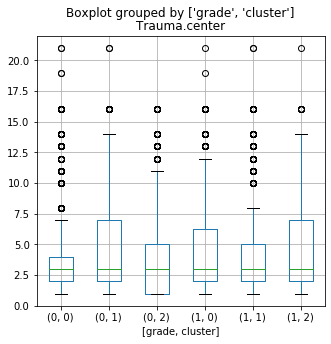

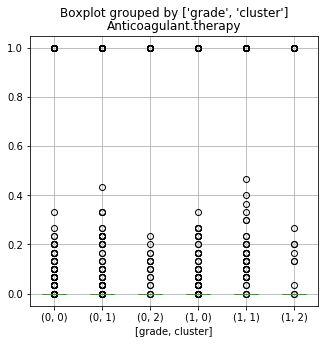

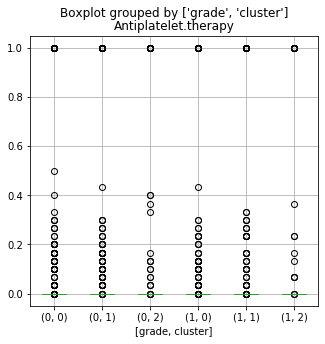

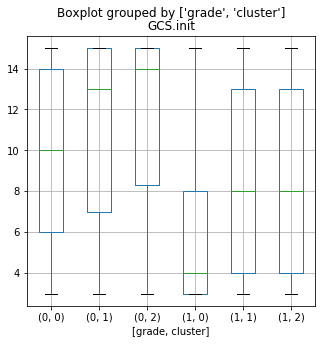

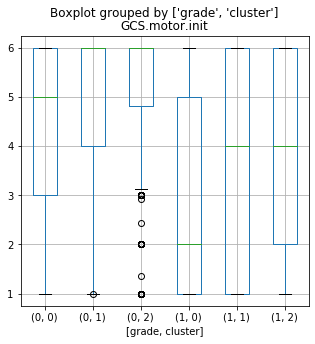

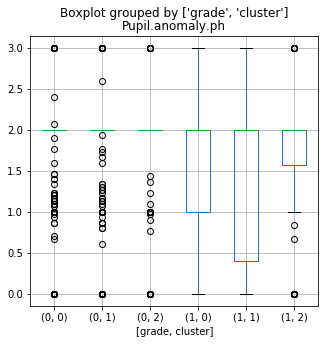

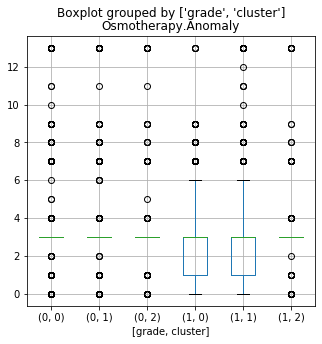

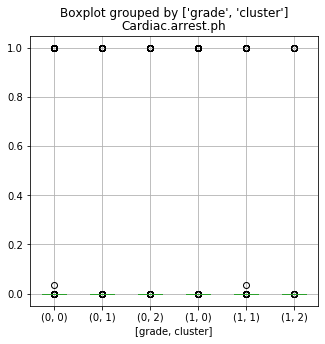

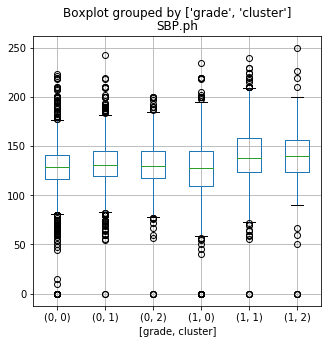

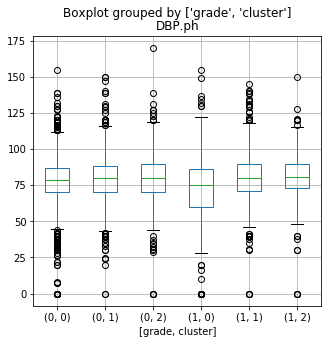

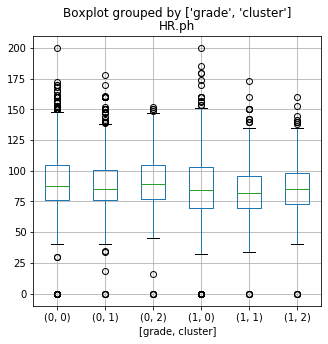

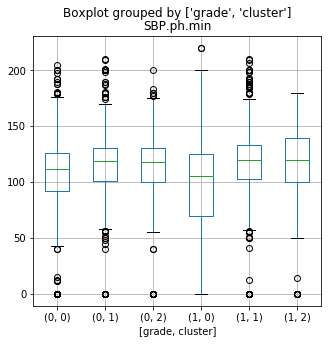

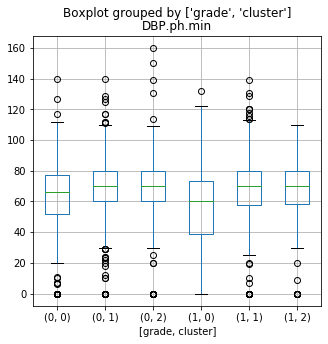

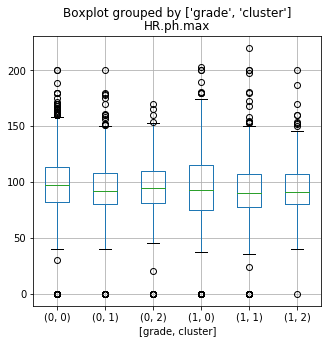

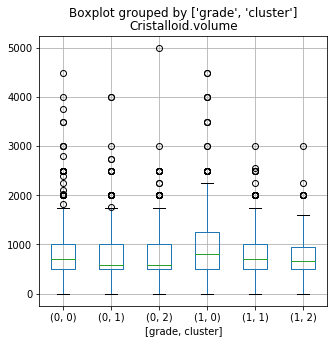

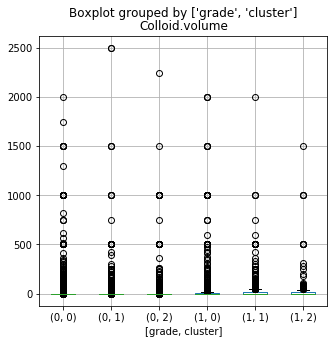

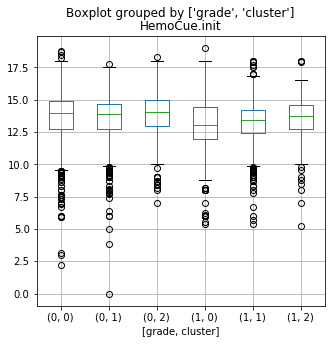

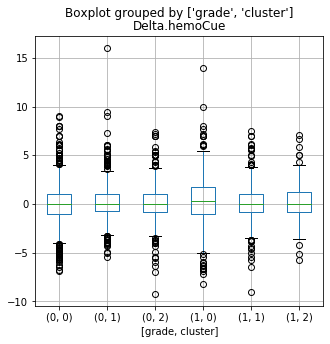

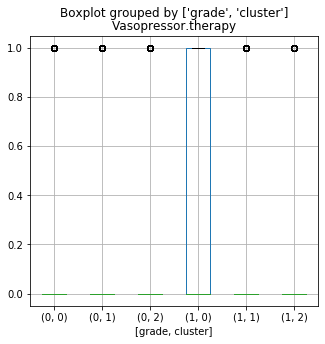

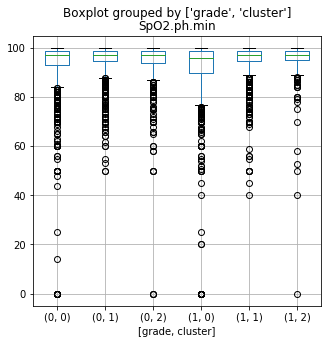

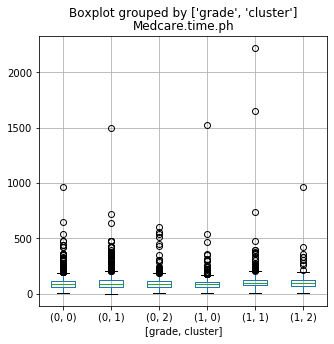

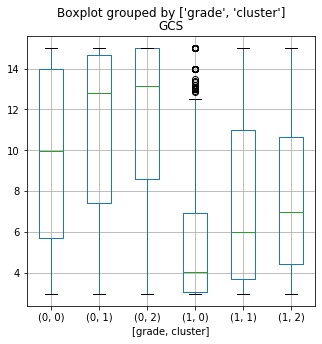

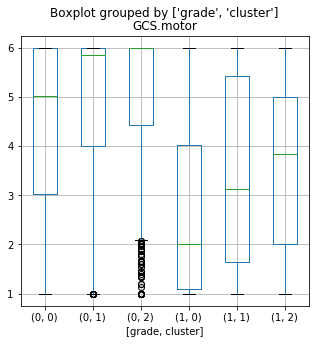

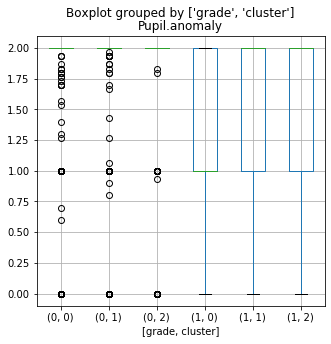

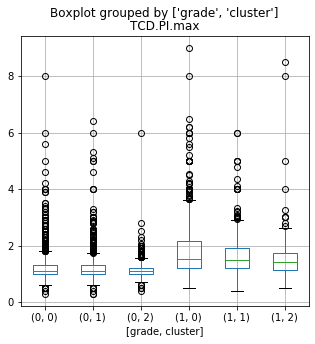

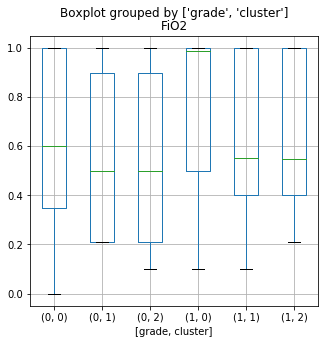

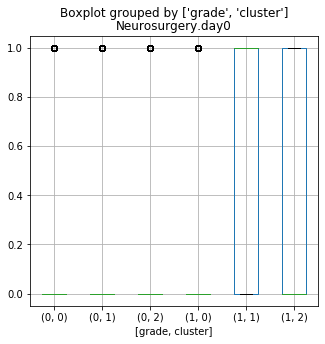

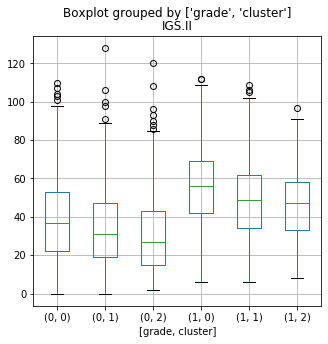

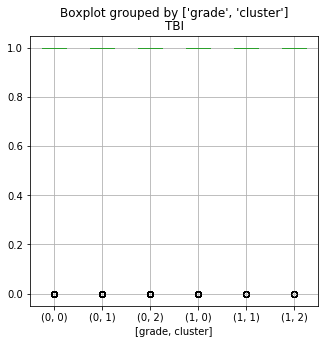

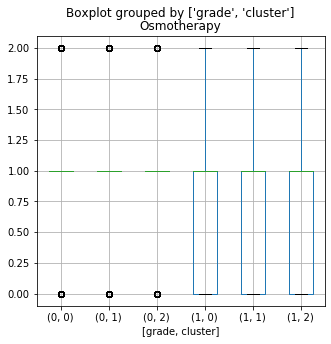

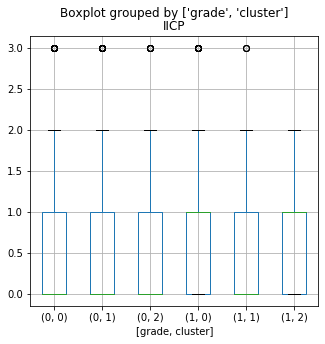

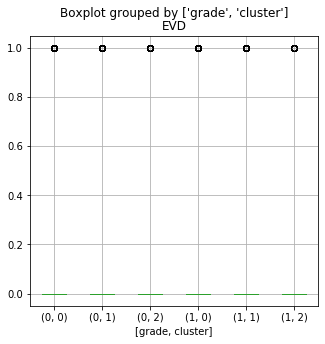

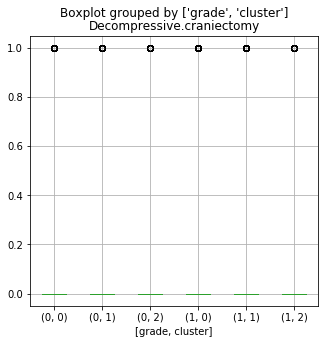

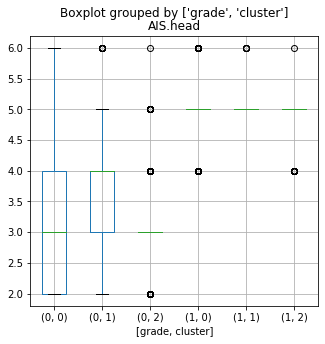

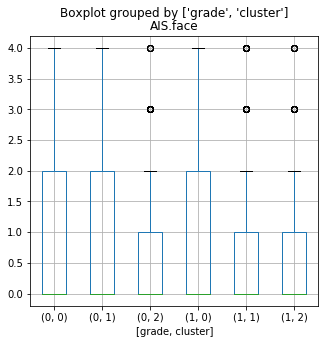

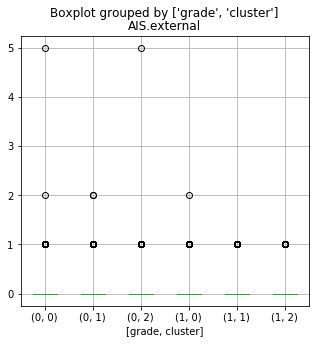

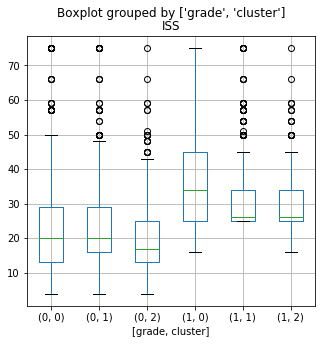

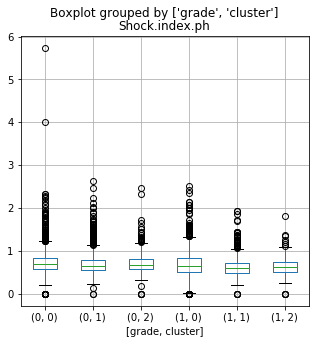

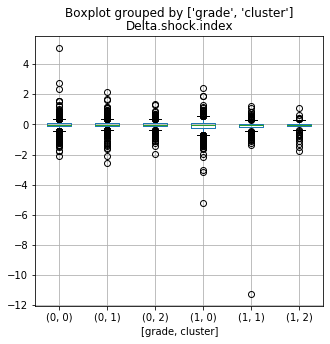

In [15]:
cols_ = Data.columns.drop(['Unnamed: 0', 'class'])
for i in range(len(cols_)):
    Data[[cols_[i], 'grade', 'cluster']].boxplot(by=['grade', 'cluster'], figsize = (5,5))